In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms

In [2]:
# Define transforms (resizing, normalization, etc.)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 256x256 for CNNs
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize
])

In [3]:
# Load dataset
train_dataset = datasets.ImageFolder(root="dogs_vs_cats/train", transform=transform)
test_dataset = datasets.ImageFolder(root="dogs_vs_cats/test", transform=transform)

In [4]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 20000
    Root location: dogs_vs_cats/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [5]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 5000
    Root location: dogs_vs_cats/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [6]:
# Create DataLoaders
Batch_Size = 32

train_dataloader = DataLoader(train_dataset, batch_size=Batch_Size, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size= Batch_Size, shuffle=True, num_workers=2)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
# device = torch.device("cpu")

In [9]:
# creating CNN Model
class Dogs_vs_Cats(nn.Module):
    def __init__(self, input_channels):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding="same"), 
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(32, 64, kernel_size=3, padding="same"), 
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(64, 128, kernel_size=3, padding="same"), 
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*28*28, 128), 
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)

        return x

In [10]:
# export CUDA_LAUNCH_BLOCKING=1

In [11]:
model = Dogs_vs_Cats(input_channels=3).to(device)

In [12]:
model

Dogs_vs_Cats(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(

In [13]:
from torchsummary import summary

In [14]:
# Print summary
# summary(model, input_size=(3, 254, 254))

In [15]:
loss_fc = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [16]:
# training loop
import time
start_time = time.time()

epochs = 10

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_dataloader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    batch_labels = batch_labels.view(-1,1).float() 

    # forward pass
    outputs = model(batch_features)

    # calculate loss
    loss = loss_fc(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(train_dataloader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')

end_time = time.time()
print(f"Total time of training is {(end_time - start_time)/60} Minutes!")

Epoch: 1 , Loss: 49.93129072780609
Epoch: 2 , Loss: 50.0
Epoch: 3 , Loss: 50.0
Epoch: 4 , Loss: 50.0
Epoch: 5 , Loss: 50.0
Epoch: 6 , Loss: 50.0
Epoch: 7 , Loss: 50.0
Epoch: 8 , Loss: 50.0
Epoch: 9 , Loss: 50.0
Epoch: 10 , Loss: 50.0
Total time of training is 22.203921457131703 Minutes!


In [17]:
model.eval()

Dogs_vs_Cats(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(

In [18]:
# evaluation on test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_dataloader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.5


## After reducing overfitting and underfitting

In [24]:
# creating CNN Model
class Dogs_vs_Cats_New(nn.Module):
    def __init__(self, input_channels):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding="same"), 
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(32, 64, kernel_size=3, padding="same"), 
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(64, 128, kernel_size=3, padding="same"), 
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*28*28, 128), 
            nn.ReLU(),
            nn.Dropout(0.3), 

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3), 

            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)

        return x

In [25]:
model1 = Dogs_vs_Cats_New(input_channels=3).to(device)

In [26]:
model1

Dogs_vs_Cats_New(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=128, bias=True)
    (2): ReLU()
    (3): Dro

In [27]:
loss_fc = nn.BCELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)

In [55]:
import time

# Start timing
start_time = time.time()

epochs = 10

train_loss_values1 = []  # Stores average loss per epoch
epoch_count1 = []

for epoch in range(epochs):
    total_epoch_loss = 0  # Reset total loss for the epoch
    num_batches = 0  # Track number of batches

    for batch_features, batch_labels in train_dataloader:
        # Move data to GPU
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        # Ensure correct label shape based on task
        batch_labels = batch_labels.view(-1, 1).float()  # For regression
        # batch_labels = batch_labels.long()  # Uncomment for classification

        # Forward pass
        outputs = model1(batch_features)

        # Compute loss
        loss = loss_fc(outputs, batch_labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate total loss
        total_epoch_loss += loss.item()
        num_batches += 1

    # Compute average loss per epoch
    avg_epoch_loss = total_epoch_loss / num_batches
    train_loss_values1.append(avg_epoch_loss)
    epoch_count1.append(epoch + 1)

    print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_epoch_loss:.4f}")

# End timing
end_time = time.time()
print(f"Total training time: {(end_time - start_time) / 60:.2f} minutes")

Epoch 1/10 - Loss: 50.0000
Epoch 2/10 - Loss: 50.0000
Epoch 3/10 - Loss: 50.0000
Epoch 4/10 - Loss: 50.0000
Epoch 5/10 - Loss: 50.0000
Epoch 6/10 - Loss: 50.0000
Epoch 7/10 - Loss: 50.0000
Epoch 8/10 - Loss: 50.0000
Epoch 9/10 - Loss: 50.0000
Epoch 10/10 - Loss: 50.0000
Total training time: 14.33 minutes


In [57]:
model1.eval()
# Evaluation on test data
test_loss_values1 = []
total = 0
correct = 0

with torch.no_grad():
    for batch_features, batch_labels in test_dataloader:
        # Move data to GPU
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        # Ensure batch_labels is of correct type
        batch_labels = batch_labels.view(-1,1).float()  # For classification
        # batch_labels = batch_labels.view(-1, 1).float()  # For regression

        outputs = model1(batch_features)

        test_loss = loss_fc(outputs, batch_labels)
        test_loss_values1.append(test_loss.item())

        _, predicted = torch.max(outputs, 1)  # Get class prediction for classification

        total += batch_labels.shape[0]
        correct += (predicted == batch_labels).sum().item()

    accuracy1 = correct / total  # Compute accuracy after loop

print(f"Test Accuracy: {accuracy1:.4f}")

Test Accuracy: 15.9760


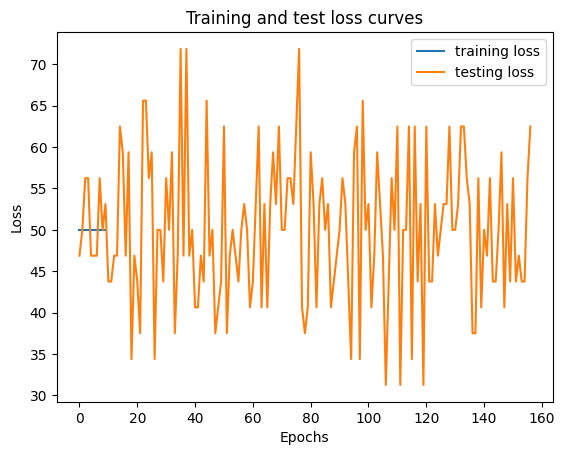

In [60]:
# Plot the loss curves
plt.plot(train_loss_values1, label="training loss")
plt.plot(test_loss_values1, label="testing loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()